**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be first graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). However, any given item may be worth 4 or 8 points; if an item is worth 8 points, you need to accordingly scale the 0-4 grade.


The total score must be re-scaled to 100. That should apply to all future assignments so that Canvas assigns the same weight on all assignments. 



In [ ]:
!pip install d2l==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np 
import pandas as pd 
import torchtext.data as ttd
from torch import nn
from torch.nn import functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import widgets

print("I am the first print statement of the cell")

# Now we can create a grid, optional header_row and header_column
# control whether we want header elements in the grid
grid = widgets.Grid(2, 2, header_row=True, header_column=True)
with grid.output_to(1, 1):
  print("Bye grid")

# Note we can output to arbitrary cell, not necessarily in order
with grid.output_to(0, 0):
  print("Hello grid")

print("Now we are outside")

with grid.output_to(1, 0):
  print("Back inside!")

I am the first print statement of the cell


,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bye grid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hello grid


<IPython.core.display.Javascript object>

Now we are outside


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Back inside!


<IPython.core.display.Javascript object>

# <font color = 'red'>   **Assignment 4**


In this assignment we will look into details of the RNN for language modeling and experiment with its different parts. We will begin with the notebook that implements from scratch a simple RNN.

In [ ]:
batch_size, num_steps = 2, 5
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
for X, y in train_iter:
  print(X)
  print(y)
  break


tensor([[ 3,  5, 13,  2,  1],
        [14, 11,  2,  1, 17]])
tensor([[ 5, 13,  2,  1, 13],
        [11,  2,  1, 17,  4]])


In [ ]:
batch_size, num_steps = 28, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding

Recall that each token is represented as a numerical index in `train_iter`.
Feeding these indices directly to a neural network might make it hard to
learn.
We often represent each token as a more expressive feature vector.
The easiest representation is called *one-hot encoding*.



In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the minibatch that we sample each time is (batch size, number of time steps).
The `one_hot` function transforms such a minibatch into a three-dimensional tensor with the last dimension equals to the vocabulary size (`len(vocab)`).
We often transpose the input so that we will obtain an
output of shape
(number of time steps, batch size, vocabulary size).
This will allow us
to more conveniently
loop through the outermost dimension
for updating hidden states of a minibatch,
time step by time step.


In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, we initialize the model parameters for
the RNN model.
The number of hidden units `num_hiddens` is a tunable hyperparameter.
When training language models,
the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.


In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model,
we first need an `init_rnn_state` function
to return the hidden state at initialization.
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which we will encounter in later sections.


In [ ]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following `rnn` function defines how to compute the hidden state and output
at a time step.
Note that
the RNN model
loops through the outermost dimension of `inputs`
so that it updates hidden states `H` of a minibatch,
time step by time step.

In [ ]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined,
next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.


In [ ]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [ ]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let us first define the prediction function
to generate new characters following
the user-provided `prefix`,
which is a string containing several characters.
When looping through these beginning characters in `prefix`,
we keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So we generate the predicted characters and emit them.


In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict_ch8` function.
We specify the prefix as `time traveller ` and have it generate 10 additional characters.
Given that we have not trained the network,
it will generate nonsensical predictions.


In [ ]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller tmzgamzgam'

## Gradient Clipping

<br>

In [ ]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Before training the model,
let us define a function to train the model in one epoch. Here are some non-standard aspects of it. 

1. Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.
1. We use perplexity to evaluate the model. As discussed in :numref:`subsec_perplexity`, this ensures that sequences of different length are comparable.


Specifically,
when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch.
Since the $i^\mathrm{th}$ subsequence example  in the next minibatch is adjacent to the current $i^\mathrm{th}$ subsequence example,
the hidden state at the end of the current minibatch
will be
used to initialize
the hidden state at the beginning of the next minibatch.
In this way,
historical information of the sequence
stored in the hidden state
might flow over
adjacent subsequences within an epoch.
However, the computation of the hidden state
at any point depends on all the previous minibatches
in the same epoch,
which complicates the gradient computation.
To reduce computational cost,
we detach the gradient before processing any minibatch
so that the gradient computation of the hidden state
is always limited to
the time steps in one minibatch. 

When using the random sampling,
we need to re-initialize the hidden state for each iteration since each example is sampled with a random position.



In [ ]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports an RNN model implemented
either from scratch or using high-level APIs.


In [ ]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train the RNN model.
Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.2, 84238.3 tokens/sec on cuda:0
time traveller proceeded anyreal body must have exed and urally 
traveller whod bais oult some time sime a can allist the oc


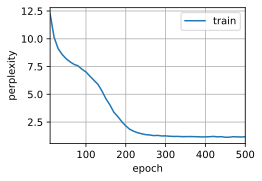

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally,
let us check the results of using the random sampling method.


perplexity 1.3, 85220.2 tokens/sec on cuda:0
time traveller proceeded anyreal body must have extension in fou
traveller proceeded anyreal body must have extension in fou


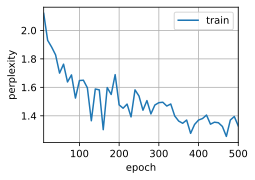

In [ ]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## <font color = 'red'>   **Question 1**

<font color = 'red'>  The model has a number of hyperparameters, e.g. number of epochs, number of hidden units, number of steps in minibatch, and learning rate. Adjust these hyperparameters and try to improve the perplexity of the model. Show your work and report the perplexity you were able to achieve.

perplexity 1.0, 87540.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


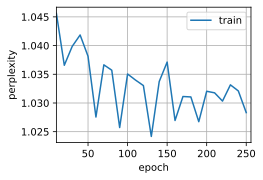

In [ ]:
num_epochs, lr = 256, 0.01
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.0, 83630.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


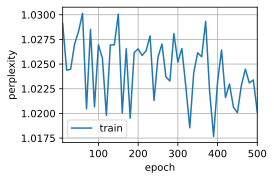

In [ ]:
num_epochs, lr = 500, 0.01
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 22.4, 84127.5 tokens/sec on cuda:0
time traveller banensr ougr haters be on theral aren ane the thi
travellerou therd andin ther anerr onedinte that oral oren 


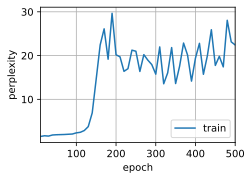

In [ ]:
num_epochs, lr = 500, 1.5
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

perplexity 111.6, 82117.0 tokens/sec on cuda:0
time travellereng mou fame doe do soo eno exo eno eno eno eno en
travellerand ae oe do exo exo eno eno eno eno eno eno eno e


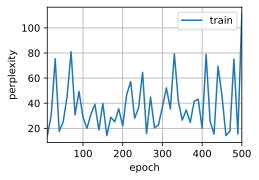

In [ ]:
num_epochs, lr = 500, 1.5
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 11.1, 85358.1 tokens/sec on cuda:0
time travellere s mfr fime the thatis the the the the the the th
travellerend arent hand on in an ar the ande the the the th


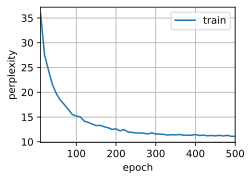

In [ ]:
num_epochs, lr = 500, 0.001

with grid.output_to(0, 0): 
  print()
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 11.2, 80364.2 tokens/sec on cuda:0
time travellere fo dfspithedhe hed the int an the the the the th
travellerend arenc hand on int in the the the the the the t


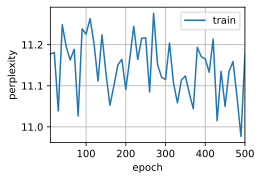

In [ ]:
num_epochs, lr = 500, 0.0001
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 15.7, 81539.2 tokens/sec on cuda:0
time travellere fo dfspitus he fou thing the the the the the the
travellerend arenc hou the hon hon the the ton the the ton 


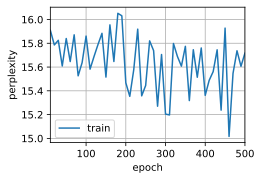

In [ ]:
num_epochs, lr = 500, 0.0001
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

perplexity 9.7, 89107.4 tokens/sec on cuda:0
time traveller sou davn theph ar and the there the the the the t
travellereping yn ihe t ale than the the that the the than 


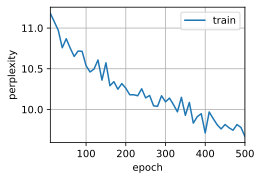

In [ ]:
num_epochs, num_hiddens, lr = 500, 2, .01
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [ ]:
batch_size, num_steps = 200, 2 
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 10.1, 199634.7 tokens/sec on cuda:0
time traveller inged ins and the mere the the the the than the t
travelleren ton the thin an tan or on the the ther the that


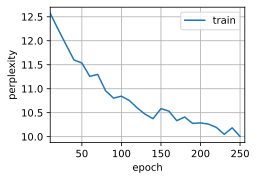

In [ ]:
num_epochs, num_hiddens, lr = 256, 14, .01
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 9.1, 212394.5 tokens/sec on cuda:0
time traveller ing an thav time at the the the the the the the t
traveller ant an and he the the the haren the ther thave th


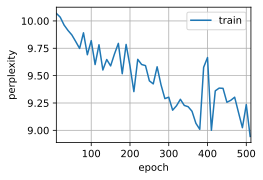

In [ ]:
num_epochs, num_hiddens, lr = 512, 14, .01
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

## <font color = 'navy'> Evaluating Question 1: </font>

After training various parameters on the model, perplexity of `1.0` was found to be the best result with original model using the following: <br /><br />


`num_epochs` = `500` <br />
`lr` = `0.0001` <br />
`result` = `perplexity 1.0, 68639.4 tokens/sec on cuda:0` <br />
*time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi*<br /><br />


A close candidate by adding `num_hiddens` to the same model produced the following: <br /><br />

`num_epochs` = `500` <br />
`num_hiddens` = `2` <br />
`lr` = `.01` <br />
`perplexity 1.0, 68409.7 tokens/sec on cuda:0` <br />
`result` = *time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi* <br /><br />

<hr />
<br />

Switching `batch_size` and `num_steps` did not perform as well, additionally. The below result showed higher perplexity scores: <br /><br />

`batch_size` = `200` <br />
`num_steps` = `2` <br />
`epochs` = `256` <br />
`num_hiddens` = `14` <br />
`lr` = `0.01` <br />
`perplexity 1.1, 175344.9 tokens/sec on cuda:0` <br />
`result` = *time traveller smiled are you sure we can move freely inspace ri
traveller with a slight accession ofcheerfulness really thi*


In [ ]:
# for grader use only

# insert grade here  (out of 4)

# G[1] = 
#
# please justify point subtractions when needed

## <font color = 'red'>   **Question 2**

<font color = 'red'> Replace the one-hot encoding with a set of learnable parameters (embedding). You can begin by finding where the one hot encoding of tokens is applied to the data, and instead use that trainable embedding in that place. Show your work. What do you observe, in terms of perplexity?
<font color = 'red'>  

In [ ]:
def __init__(self, vocab_size, embed_size, hidden_size, device):
  self.hidden_size = hidden_size
  self.embedding = nn.Embedding(vocab_size+1, embed_size, device=device)
  self.rnn = nn.RNN(embed_size, hidden_size, num_layers = 1, batch_first = True)

def forward(self, X):
  X = X
  X = self.embedding(X) # batch-size x seq_length x embedding_dimension
  X,_ = self.rnn(X) #batch-size x seq_length x hidden_size
  X = torch.sigmoid(X[:,:,-1][:,-1])
  return X

In [ ]:
class RNNModelScratchEmbed: 
    """A RNN Model implemented from scratch with an Embedding layer.""" 
    def __init__(self, vocab_size, num_hiddens, device, embed_size, 
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_rnn_state, forward_fn
        self.embedding = nn.Embedding(vocab_size, embed_size, device=device) # Embedding layer

    def __call__(self, X, state):
        X = self.embedding(X.T).to(device) # Embedding layer to device for X
        #X = F.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
embed_size = 28
num_hiddens = 8
model = RNNModelScratchEmbed(len(vocab), num_hiddens, device, embed_size,
                             init_rnn_state, rnn)
state = model.begin_state(X.shape[0], device)
Y, new_state = model(X.to(device), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 8]))

perplexity 10.6, 229739.6 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


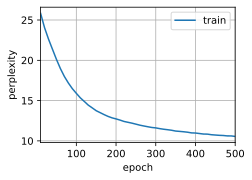

In [ ]:
num_epochs, lr = 500, .01
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 8.6, 236073.0 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


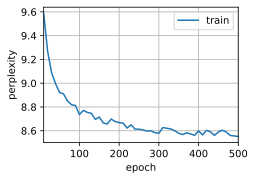

In [ ]:
num_epochs, num_hiddens, lr = 500, 16, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 8.4, 237962.0 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


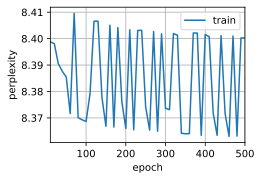

In [ ]:
num_epochs, num_hiddens, lr = 500, 56, .01
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 8.4, 235473.8 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


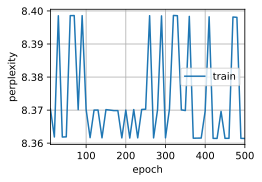

In [ ]:
num_epochs, lr = 500, .001
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 8.4, 236687.7 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


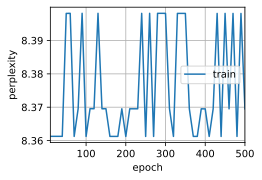

In [ ]:
num_epochs, num_hiddens, lr = 500, 28, .0001
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## <font color = 'navy'> Evaluating Question 2: </font>

I used similiar parameters to compare each model. My results for substituting the `one_hot` method with `nn.Embedding`, did not perform any better score than what was previously reported from Q1 `Perplexity` score of `1.0`. 

In [ ]:
# for grader use only

# insert grade here  (out of 4)

# G[2] = 
#
# please justify point subtractions when needed

## <font color = 'red'>   **Question 3**

<font color = 'red'> The prediction function implemented above, outputs as the next character the most probable character. Locate the part of the code where that happens, and replace it with code that **samples** the next character according to the probabilities generated by the model.

<font color = 'red'>  Hint: Rrecall that the model outputs a vector of probabilities for each character/token given what it has seen prior to that. You may want to check the documentation for *numpy.random.choice*. 

In [ ]:
def new_predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        #y_idx = int(torch.randperm(len(y[0])))[:1]
        #y_idx = torch.randint(len(y[0]), (1,))
        #indices = torch.ones(len(y[0]))
        # normalize values between 0 and 1
        new_y = y
        new_y -= new_y.min()
        new_y /= new_y.max()
        # using tensor.multinomial() equivalent to np.random.choice
        y_idx = new_y.multinomial(1, replacement=True)
        outputs.append(int(y_idx))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
new_predict_ch8('the time traveller ', 10, net, vocab, device)

'the time traveller wyybd gsol'

In [ ]:
# for grader use only

# insert grade here  (out of 8)

# G[1] = 
#
# please justify point subtractions when needed

In [ ]:
# total score
max_score = 16
$inal_score = sum(G)*(100/max_score)